In [1]:
import sys, platform
import pandas as pd
import numpy as np
import sklearn
import fairlearn

import matplotlib.pyplot as plt
import re
from pathlib import Path
from IPython.display import display

from src.data_loading import load_adult_income_dataset, load_german_credit_dataset

# Checking which versions are used in the current environment
print("Python:", platform.python_version())
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)
print("fairlearn:", fairlearn.__version__)

# Ensuring the output directory exists before writing any result tables or saving plots
# If results/ is missing, it will be created; if it already exists, nothing happens
RESULTS_DIR = Path("results")
PLOTS_DIR = RESULTS_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

Python: 3.12.10
numpy: 2.2.6
pandas: 2.3.3
scikit-learn: 1.7.2
fairlearn: 0.13.0


In [2]:
def safe_filename(s: str) -> str:
    s = str(s).lower().strip()
    s = re.sub(r"[^\w\s-]", "", s)
    s = re.sub(r"[\s]+", "_", s)
    return s[:120]

def unique_path(base_path: Path) -> Path:
    # Avoiding overwriting: if file exists, add _2, _3, ...
    if not base_path.exists():
        return base_path
    stem = base_path.stem
    suffix = base_path.suffix
    i = 2
    while True:
        candidate = base_path.with_name(f"{stem}_{i}{suffix}")
        if not candidate.exists():
            return candidate
        i += 1

def save_plot(title: str, filename: str | None = None, dpi: int = 200):
    """
    Saving the current matplotlib figure to results/plots as PNG.
    """
    if filename is None:
        filename = safe_filename(title) or "plot"
        filename = filename + ".png"

    path = unique_path(PLOTS_DIR / filename)

    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    # marking current figure as already saved (prevents double-save if called twice)
    fig = plt.gcf()
    setattr(fig, "_autosave_done", True)

    print("Saved plot:", path.as_posix())


# auto save feature when plt.show() is called
_ORIGINAL_SHOW = plt.show  # keeping reference so it can be restored if needed
_PLOT_COUNTER = 0

def get_current_plot_title() -> str:
    fig = plt.gcf()

    # Suptitle
    st = getattr(fig, "_suptitle", None)
    if st is not None and st.get_text().strip():
        return st.get_text().strip()

    # Fallback to first axes title
    axes = fig.get_axes()
    if axes and axes[0].get_title().strip():
        return axes[0].get_title().strip()

    return ""

def autosave_current_figure_if_needed():
    global _PLOT_COUNTER
    fig = plt.gcf()

    # If this figure was already saved, skip (prevents duplicates)
    if getattr(fig, "_autosave_done", False):
        return

    title = get_current_plot_title()
    if not title:
        _PLOT_COUNTER += 1
        title = f"plot_{_PLOT_COUNTER:03d}"

    save_plot(title)

def show(*args, **kwargs):
    # Saving before showing
    try:
        autosave_current_figure_if_needed()
    except Exception as e:
        print("WARNING: autosave failed:", e)

    return _ORIGINAL_SHOW(*args, **kwargs)

# Monkey-patch matplotlib show
plt.show = show
print("Autosave enabled: every plt.show() will also save a PNG to results/plots/")


Autosave enabled: every plt.show() will also save a PNG to results/plots/


In [3]:
# Quick sanity-check, load each dataset split (train/val/test) and print the resulting shapes
splits = ["train", "val", "test"]

for split in splits:
    X, y, A, df = load_adult_income_dataset(split)
    # X.shape = (rows, features), len(y) = number of labels, df.shape = raw dataframe shape (incl. dropped columns)
    print(f"[Adult income] split={split} X={X.shape} y={len(y)} df={df.shape}")

for split in splits:
    X, y, A, df = load_german_credit_dataset(split)
    print(f"[German credit] split={split} X={X.shape} y={len(y)} df={df.shape}")


[Adult income] split=train X=(24129, 13) y=24129 df=(24129, 16)
[Adult income] split=val X=(6033, 13) y=6033 df=(6033, 16)
[Adult income] split=test X=(15060, 13) y=15060 df=(15060, 16)
[German credit] split=train X=(600, 19) y=600 df=(600, 24)
[German credit] split=val X=(200, 19) y=200 df=(200, 24)
[German credit] split=test X=(200, 19) y=200 df=(200, 24)


In [4]:
# Displaying the first 5 rows of the  dataframe for a quick sanity-check
X_a, y_a, A_a, df_a = load_adult_income_dataset("train")
X_g, y_g, A_g, df_g = load_german_credit_dataset("train")

print("Adult income df head:")
display(df_a.head())

print("German credit df head:")
display(df_g.head())


Adult income df head:


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,income_binary
0,25,Private,198870,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Male,0,0,35,United-States,<=50K,0
1,60,Federal-gov,119832,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,7298,0,40,United-States,>50K,1
2,23,Private,122272,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,United-States,<=50K,0
3,29,Private,87507,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,60,India,<=50K,0
4,23,Private,245302,Some-college,10,Divorced,Sales,Own-child,Black,Female,0,0,40,United-States,<=50K,0


German credit df head:


,status_existing_checking,duration_months,credit_history,purpose,credit_amount,savings,employment_since,installment_rate,personal_status_sex,other_debtors,...,housing,existing_credits,job,people_liable,telephone,foreign_worker,target_raw,sex,credit_risk,credit_risk_binary
0,A13,12,A32,A42,2251,A61,A73,1,A92,A101,...,A152,1,A172,1,A191,A201,1,female,good,1
1,A14,12,A34,A49,1264,A65,A75,4,A93,A101,...,A151,1,A172,1,A191,A201,1,male,good,1
2,A14,13,A32,A43,1409,A62,A71,2,A92,A101,...,A152,1,A173,1,A191,A201,1,female,good,1
3,A14,12,A32,A40,1101,A61,A73,3,A94,A101,...,A152,2,A173,1,A192,A201,1,male,good,1
4,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A152,1,A173,1,A191,A201,1,male,good,1


In [5]:
def missing_report(df, name):
    # Counting missing values (NaNs) per column
    miss = df.isna().sum()
    # Keeping only columns that actually have missing values, sorted from most to least missing
    miss = miss[miss > 0].sort_values(ascending=False)
    # Printing a simple data quality report
    print(f"Missing values report: {name}")
    if len(miss) == 0:
        # <Confirm that nothing is missing
        print("  No NA values detected.")
    else:
        # Displaying columns with missing values and their counts
        display(miss)
# missing-value check on the training splits of both datasets
missing_report(df_a, "Adult income (train)")
missing_report(df_g, "German credit (train)")


Missing values report: Adult income (train)
  No NA values detected.
Missing values report: German credit (train)
  No NA values detected.


Adult Income — y distribution (train)


income_binary
0    18123
1     6006
Name: count, dtype: int64

Saved plot: results/plots/adult_income_y_distribution_train.png


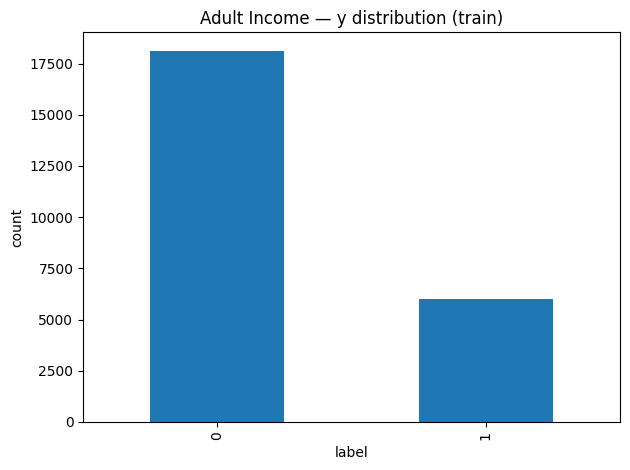

German Credit — y distribution (train)


credit_risk_binary
1    420
0    180
Name: count, dtype: int64

Saved plot: results/plots/german_credit_y_distribution_train.png


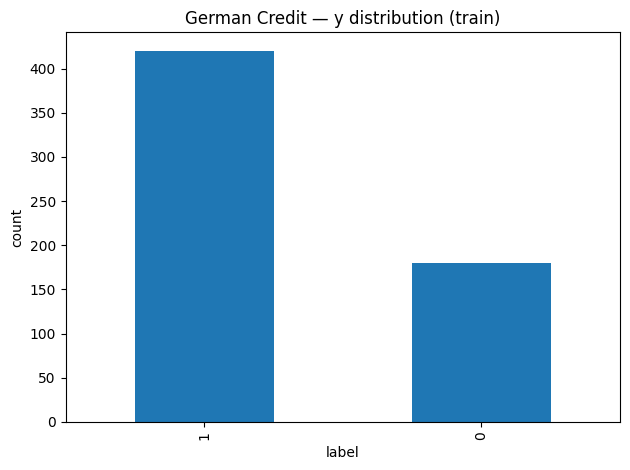

In [6]:
def plot_target(y, title):
    # Converting the target vector to a pandas Series
    s = pd.Series(y)
    # Counting how many samples belong to each class label
    counts = s.value_counts(dropna=False)
    # Print the counts 
    print(title)
    display(counts)

    # Plot the class distribution 
    plt.figure()
    counts.plot(kind="bar")
    plt.title(title)
    plt.xlabel("label")
    plt.ylabel("count")
    plt.show()
# Visualizing class balance for the training splits of both datasets
plot_target(y_a, "Adult Income — y distribution (train)")
plot_target(y_g, "German Credit — y distribution (train)")


Adult Income — group distribution: sex (train)


sex
Male      16315
Female     7814
Name: count, dtype: int64

Saved plot: results/plots/adult_income_group_distribution_sex_train.png


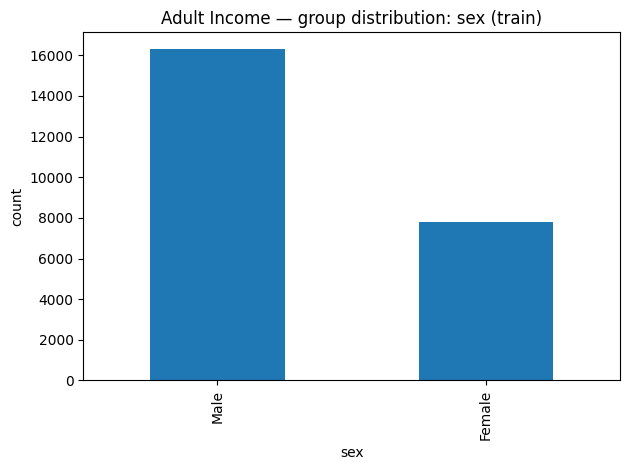

Adult Income — group distribution: race (train)


race
White                 20747
Black                  2258
Asian-Pac-Islander      709
Amer-Indian-Eskimo      222
Other                   193
Name: count, dtype: int64

Saved plot: results/plots/adult_income_group_distribution_race_train.png


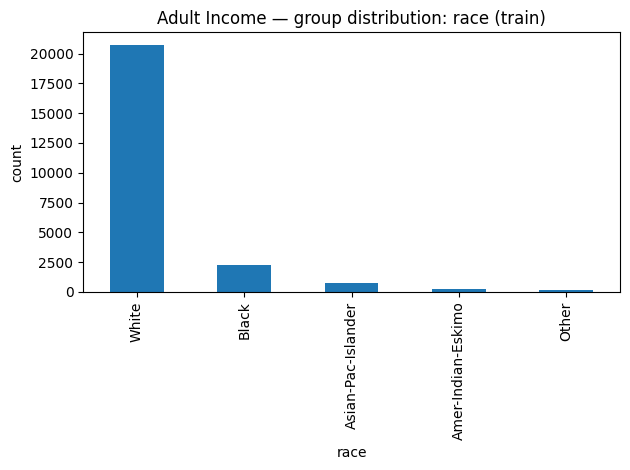

German Credit — group distribution: sex (train)


sex
male      406
female    194
Name: count, dtype: int64

Saved plot: results/plots/german_credit_group_distribution_sex_train.png


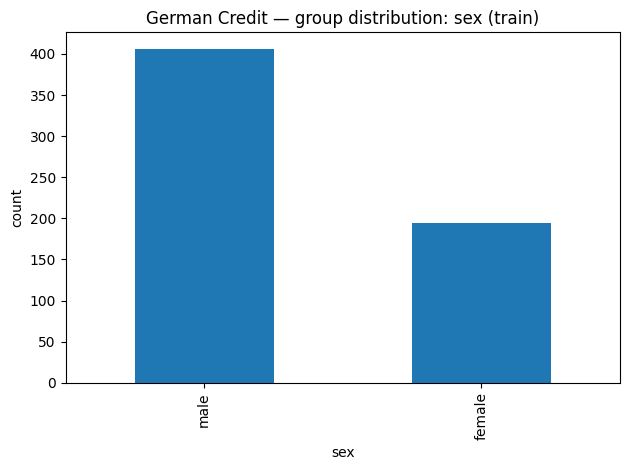

In [7]:
def plot_group(df, col, title):
    # Counting how many samples fall into each group/category for the selected column
    counts = df[col].value_counts(dropna=False)
    # Print the exact group counts
    print(title)
    display(counts)
    # Plot the group distribution as a bar chart
    plt.figure()
    counts.plot(kind="bar")
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()
    
# Plot sensitive/protected group distributions (train split)
if "sex" in df_a.columns:
    plot_group(df_a, "sex", "Adult Income — group distribution: sex (train)")

if "race" in df_a.columns:
    plot_group(df_a, "race", "Adult Income — group distribution: race (train)")

if "sex" in df_g.columns:
    plot_group(df_g, "sex", "German Credit — group distribution: sex (train)")
